# Hyperparameter Evaluation - __Dense NN__ with Tile Data Set

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import multiprocessing 

## Helper Functions

The standard <code>read_data()</code> function seen throughout the project. designed to simplify and standardize the data reading process. <br/>In addition the _Global_ variables associated with its function are defined along with the relitive paths to the data files.<br/>__NOTE:__ in a business environment this function would be placed into a pythin module and imported. Here it is included into the notebook to provide full transparency. 

In [2]:
# required modules
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing
import colorsys

# groups
COLOURS      = 10
PALETTES     = 11
LRG_PALETTES = 12
IMAGE        = 13
TILES        = 14

# sets
TRAIN        = 20
TEST         = 21
VALIDATE     = 22

# targets
ARTIST       = 30
GENRE        = 31
STYLE        = 32

# array
DATA         = 40
CATAGORY     = 41
CATAGORY_NUM = 42
IMAGE_TAG    = 43
TILE_INDEX   = 44

# colour systems
HLS          = 50
RGB          = 51
RAW          = 52

# an overly complicated method of defining the data file path
data_file  = {COLOURS      : {TRAIN    : {ARTIST : "./data/colour_sets/artist_train_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_train_colours.npz",
                                          STYLE  : "./data/colour_sets/style_train_colours.npz"},
                              TEST     : {ARTIST : "./data/colour_sets/artist_test_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_test_colours.npz",
                                          STYLE  : "./data/colour_sets/style_test_colours.npz"} ,
                              VALIDATE : {ARTIST : "./data/colour_sets/artist_validation_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_validation_colours.npz",
                                          STYLE  : "./data/colour_sets/style_validation_colours.npz"}},
              PALETTES     : {TRAIN    : {ARTIST : "./data/palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_validation_palettes.npz"}},
              LRG_PALETTES : {TRAIN    : {ARTIST : "./data/large_palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/large_palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/large_palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_validation_palettes.npz"}},
              IMAGE        : {TRAIN    : {ARTIST : "./data/full_image_feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/full_image_feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/full_image_feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_validation_features.npz"}},
              TILES        : {TRAIN    : {ARTIST : "./data/feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/feature_sets/style_validation_features.npz"}}}

# Create a DB connection between python and the file system
conn = sqlite3.connect("./data/database/artist.db")

# the fuction that provides a standard data read method
def read_data(data_group, data_set, data_target, data_type, colour_system = RGB):
    
    # read the data file
    data = np.load(data_file[data_group][data_set][data_target], allow_pickle=True)

    # if tile index is requested
    if   data_type    == TILE_INDEX:
        # when group is tiles, return the tile indexes
        if data_group == TILES:
            return pd.DataFrame(data["arr_3"], columns = {"tile_index"})
        # otherwise, just return an emtpy dataset
        else:
            return pd.DataFrame(columns = {"tile_index"})
    # if image tags are requested
    elif data_type == IMAGE_TAG:
        return pd.DataFrame(data["arr_2"], columns = {"image_tag"})
    # if catagory data is requested
    elif data_type == CATAGORY:
        return pd.DataFrame(data["arr_1"], columns = {"catagory"})
    # if catagory_num is requested
    elif data_type == CATAGORY_NUM:
        # select data for the appropriate lookup table
        if   data_target == ARTIST: 
            query_string = "SELECT ID, NAME  AS VALUE FROM ARTIST"
        elif data_target == GENRE:
            query_string = "SELECT ID, GENRE AS VALUE FROM GENRE"
        else:
            query_string = "SELECT ID, STYLE AS VALUE FROM STYLE" 
        # build the lookup table
        lookup = pd.read_sql_query(query_string, conn)
        # get the catagory data
        data   = pd.DataFrame(data["arr_1"], columns = {"catagory"})
        # convert the catagory text labels to numeric catagory ids
        return pd.DataFrame(data["catagory"].apply(lambda x: lookup[lookup["VALUE"] == x]["id"].values[0]))
    # data requested
    elif data_group == COLOURS:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[1] * data["arr_0"].shape[2])))
    elif data_group == PALETTES or data_group == LRG_PALETTES:

        # extract the colour data
        colour_data = data["arr_0"]
        
        # find the datas dimensions
        records, _, palette_length, palette_layers = np.shape(colour_data)
        
        # reshape
        colour_data = colour_data.reshape(records * palette_length, palette_layers)
        
        # convert to a dataframe
        colour_data_df = pd.DataFrame(colour_data, columns =["r","g","b"])
        
        # process the data with different colour systems
        
        # hue, luminance, saturation
        if colour_system == HLS:
            
            # define a dataframe to hold the hls values
            hls_data_df = pd.DataFrame(columns =["h","l","s"])

            # loop through each record
            for row in colour_data_df.iterrows():
                
                # extract the r,g,b values and devide them by 255 ready to convert
                r, g, b = row[1].values/255

                # convert the values and add them to the dataframe
                hls_data_df.loc[len(hls_data_df)] = colorsys.rgb_to_hls(r, g, b)
            
            # create datasets and normalize
            hue        = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["h"]).reshape(records, palette_length)))
            luminance  = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["l"]).reshape(records, palette_length)))
            saturation = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["s"]).reshape(records, palette_length)))  
            
            # return values
            return hue, luminance, saturation
            
        # red, green, blue unnormalized
        elif colour_system == RAW:
            red   = pd.DataFrame(np.array(colour_data_df["r"]).reshape(records, palette_length))
            green = pd.DataFrame(np.array(colour_data_df["g"]).reshape(records, palette_length))
            blue  = pd.DataFrame(np.array(colour_data_df["b"]).reshape(records, palette_length))
            
            # return values
            return red, green, blue            
            
        # red, green, blue normalized- (default)
        else:
    
            # create datasets and normalize
            red   = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["r"]).reshape(records, palette_length)))
            green = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["g"]).reshape(records, palette_length)))
            blue  = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["b"]).reshape(records, palette_length)))
            
            # return values
            return red, green, blue

    elif data_group == IMAGE:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[2])))
    else:
        # normalize the data
        return pd.DataFrame(preprocessing.normalize(data["arr_0"])) 

The <code>get_colours()</code> function provides a list of colours the length of the value <code>no_of_colours</code>. This can be useful for consisten colours when used across multiple plots. 

In [4]:
# required modules
import random

# define colours used 
def get_colours(no_of_colours):
    
    # consistent randomness
    random.seed(42)
    
    # colour list
    colours = []

    # generate colours
    for i in range(no_of_colours):
        colours.append('#%06X' % random.randint(0, 0xFFFFFF))
    
    # return the colour list
    return colours

Generate sorted lists of _Artists, Genres_ & _Styles_. These are used in a variety of situations. These functions ensure that the lists are always defined in the same order.

In [5]:
# define data lists
artists = list(set(read_data(COLOURS, TRAIN, ARTIST, CATAGORY)["catagory"]))
styles  = list(set(read_data(COLOURS, TRAIN, STYLE,  CATAGORY)["catagory"]))
genres  = list(set(read_data(COLOURS, TRAIN, GENRE,  CATAGORY)["catagory"]))

# sort the lists
artists.sort()
styles.sort()
genres.sort()

Generate a one dimensional array of zeros the length of the target set. Unlike <code>dummy</code> this array of zeros is the full length of the target set and not the length of the provided data.

In [4]:
def generate_target_zeros(data, target_type):
    
    # generate a row of zeros with the target value set to 1
    def row_zeros(value):
        zeros_array = np.zeros((1,len(target_type)))
        zeros_array[0, target_type.index(value) ] = 1
        return zeros_array
    
    # generate all of the target rows
    array_of_rows = [row_zeros(x) for x in data["catagory"]]
    
    # return a target dataframe
    return pd.DataFrame(np.reshape(array_of_rows,(len(array_of_rows),len(target_type)) )).astype(int)

## Models
As the first hyperparameter, we investigate the number of layers. Here we try 2 simple Models to see the effects of adding a single layer.

In [5]:
def get_model_1(data_width = 1280, activation_1 = "relu"):
    model = Sequential()
    model.add(Dense(data_width // 2, 
                     input_shape        = (data_width,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))

    model.add(Dense(data_width // 4, 
                     input_shape        = (data_width // 2,), 
                     activation         = activation_1))

    model.add(Dense( len(catagories), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    return model

In [6]:
def get_model_2(data_width = 1280, activation_1 = "relu", activation_2 = "relu"):
    model = Sequential()
    model.add(Dense( data_width // 2, 
                     input_shape        = (data_width,),
                     kernel_initializer = initializers.VarianceScaling(scale = 2.0, 
                                                                       seed  = 42)))

    model.add(Dense( data_width // 4, 
                     input_shape        = (data_width // 2,), 
                     activation         = activation_1))

    model.add(Dense( data_width // 8, 
                     input_shape        = (data_width // 4,), 
                     activation         = activation_2))

    model.add(Dense( len(catagories), 
                     activation         = "softmax",
                     kernel_initializer = initializers.VarianceScaling(scale = 1.0, 
                                                                       seed  = 42)))
    return model

## Further Hyperparameters
Initially there were more values for each of the following 4 hyperparameters. But, previous executions of this notebook during its creation, ruled those values out. They can be seen commented below.

In [7]:
# define parameters
activation_values = ["relu", "selu", "elu"] # initial testing ruled out the following 2 values: "sigmoid", "tanh" 
optimizer_values  = ["sgd",  "adam", ]      # initial testing ruled out the following 6 values:  "rmsprop", "adadelta", "adagrad", "adamax", "nadam", "ftrl" 
learning_rates    = [0.01, 0.1]             # initial testing ruled out the following 2 values:  0.001, 1.0
batch_sizes       = [256]                   # initial testing ruled out the following 2 values:  64, 128, 

The <code>model_test</code> function provides the testbed functionality for the various models, hayperparameters and data sets and targets.

In [9]:
def model_test(model_id, activation_1 = "", activation_2 = "",  optimizer_name = "", batch_size = 64, learning_rate = 0.1,  group = TILES, target = ARTIST, show_plots = True, show_accuracy = True, show_summary = True):
    
    # import the training data
    X_train = read_data(group, TRAIN,    target, DATA)
    y_train = generate_target_zeros(read_data(group, TRAIN,    target, CATAGORY), catagories)
    
    # import the test data
    X_test  = read_data(group, TEST,     target, DATA)
    y_test  = generate_target_zeros(read_data(group, TEST,     target, CATAGORY), catagories)
    
    # import the validataion data
    X_valid = read_data(group, VALIDATE, target, DATA)
    y_valid = generate_target_zeros(read_data(group, VALIDATE, target, CATAGORY), catagories)
    
    # select the model
    if model_id == 1:
        model = get_model_1(len(X_train.columns), activation_1 = activation_1)
    else:
        model = get_model_2(len(X_train.columns), activation_1 = activation_1, activation_2 = activation_2)
    
    # select the optimizer
    if   optimizer_name == "ftrl":
        optimizer = keras.optimizers.Ftrl(    lr = learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop( lr = learning_rate)
    elif optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(    lr = learning_rate)
    elif optimizer_name == "adadelta":
        optimizer = keras.optimizers.Adadelta(lr = learning_rate)
    elif optimizer_name == "adagrad":
        optimizer = keras.optimizers.Adagrad( lr = learning_rate)
    elif optimizer_name == "adamax":
        optimizer = keras.optimizers.Adamax(  lr = learning_rate)
    elif optimizer_name == "nadam":
        optimizer = keras.optimizers.Nadam(   lr = learning_rate)
    else:
        optimizer = keras.optimizers.SGD(     lr = learning_rate, momentum = 0.9)
        optimizer_name = "sgd"
    
    # set the pressing batch size
    batch_size = batch_size

    # compile the model
    model.compile( loss      = keras.losses.binary_crossentropy,
                   optimizer = optimizer,  
                   metrics   =["accuracy"])

    
    # Rescale train and validation data
    scaler               = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train.astype(float))
    X_test_preprocessed  = scaler.transform(    X_test.astype( float))
    X_valid_preprocessed = scaler.transform(    X_valid.astype(float))
    
    # fit the model
    history = model.fit(X_train_preprocessed,
                          y_train,
                          batch_size       = batch_size, 
                          validation_split = 0.2,
                          epochs           = 25,
                          shuffle          = True )
    
    # make a prediction
    prediction_results       = model.predict(X_test_preprocessed)
    df_prediction_results    = pd.DataFrame(prediction_results)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size = batch_size)
    
    # results
    results = pd.DataFrame().append({"classifier" : "DENSE-NN",
                                     "group"      : group,
                                     "target"     : target,
                                     "score"      : round(test_accuracy, 6),
                                     "params"     : {"model" : model_id, "activation_1" : activation_1, "activation_2" : activation_2, "optimizer_name" : optimizer_name, "batch_size" : batch_size, "learning_rate" : learning_rate }}, ignore_index = True)
         
    # save the results
    results.to_csv("./data/hyperparameter_results/Dense-NN_for_Tiles_Classifier.csv", index = False, mode = "a", header = False)    
    
    # result plots
    if show_plots:
        
        # Create two plots: one for the loss value, one for the accuracy
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

        # plot accuracy values
        ax1.plot(history.history["loss"],     label = "train loss")
        ax1.plot(history.history["val_loss"], label ="val loss")
        ax1.set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:]))) # last three values
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("loss value")
        ax1.legend()

        # plot accuracy values
        ax2.plot(history.history["acc"], label="train acc")
        ax2.plot(history.history["val_acc"], label="val acc")
        ax2.set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_acc"][-3:]))) # last three values
        
        ax2.set_xlabel("epoch")
        ax2.set_ylabel("accuracy")
        ax2.legend()
        plt.show()
        
    # output test results
    if show_accuracy:
        
        print("Test loss: {:.2f}".format(test_loss)) 
        print("Test accuracy: {:.2f}%".format(100 * test_accuracy)) 
    
    # output summary and parameters
    if show_summary:
        model.summary()
        print("Parameters - model_id: {}, activation_1: {}, activation_2: {},optimizer: {}, batch size: {}, learning rate: {}".format(model_id, activation_1, activation_2, optimizer_name, batch_size, learning_rate)) 
        print("_________________________________________________________________\n\n\n\n\n")

## Identify the Optimum Number of Neighbors for the _Genre_, _Style_ & _Artist_ Datasets
As the best results are returned. they are added to the <code>results</code> DataFrame.

In [8]:
# create a dataframe to hold the results of the tests
results = pd.DataFrame()

## Test the Models with the _GENRE_ Dataset.

Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 24us/sample - loss: 0.1207 - acc: 0.9644 - val_loss: 0.1451 - val_acc: 0.9612
Epoch 2/25
118476/118476 [==============================] - 3s 23us/sample - loss: 0.1023 - acc: 0.9663 - val_loss: 0.1441 - val_acc: 0.9606
Epoch 3/25
118476/118476 [==============================] - 3s 23us/sample - loss: 0.0971 - acc: 0.9672 - val_loss: 0.1444 - val_acc: 0.9603
Epoch 4/25
118476/118476 [==============================] - 3s 23us/sample - loss: 0.0939 - acc: 0.9679 - val_loss: 0.1457 - val_acc: 0.9598
Epoch 5/25
118476/118476 [==============================] - 3s 23us/sample - loss: 0.0915 - acc: 0.9683 - val_loss: 0.1459 - val_acc: 0.9598
Epoch 6/25
118476/118476 [==============================] - 3s 23us/sample - loss: 0.0895 - acc: 0.9688 - val_loss: 0.1457 - val_acc: 0.9596
Epoch 7/25
118476/118476 [==============================] - 3s 23us/sample - loss: 0.0879 - acc: 0.9691

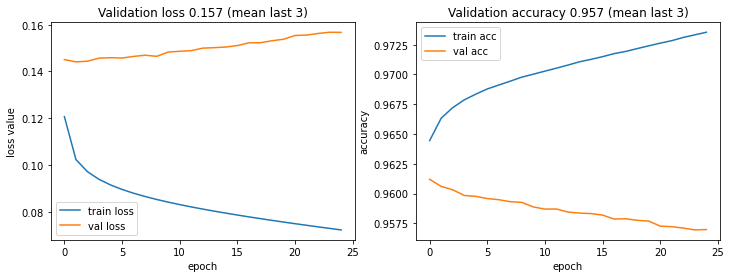

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.3186 - acc: 0.958

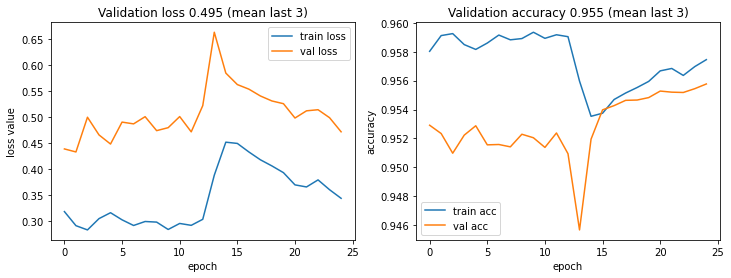

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.1304 - acc: 0.96

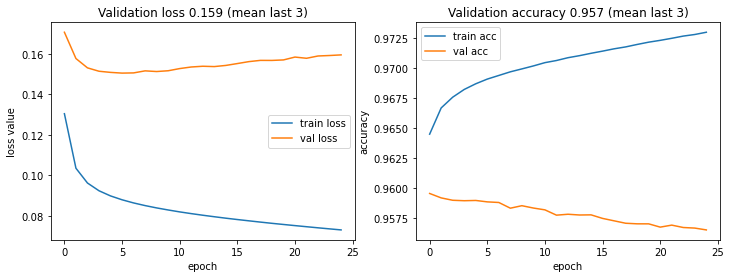

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 26us/sample - loss: 0.8114 - acc: 0.946

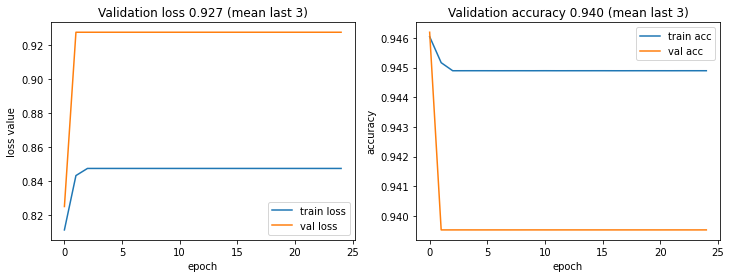

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 24us/sample - loss: 0.1225 - acc: 0.96

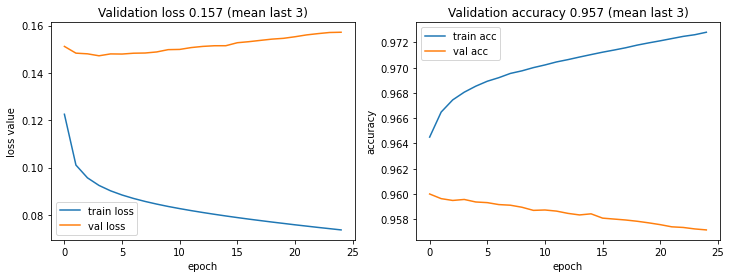

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.3857 - acc: 0.9527

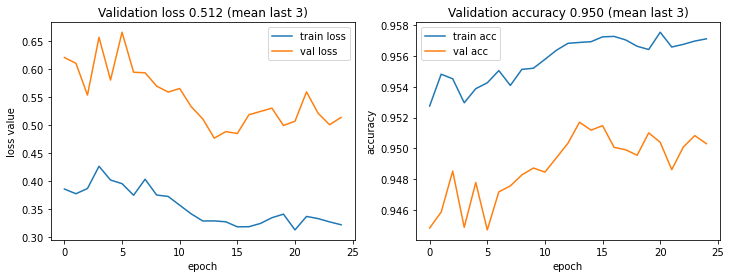

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 24us/sample - loss: 0.0983 - acc: 0.967

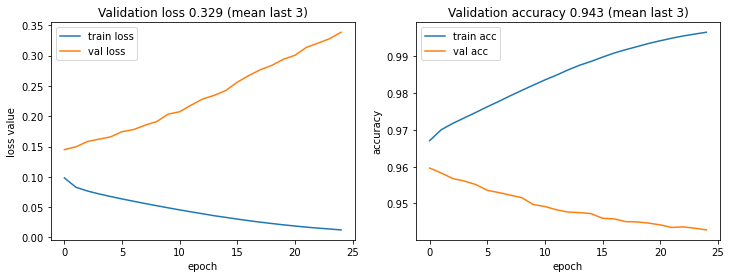

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.8478 - acc: 0.9448

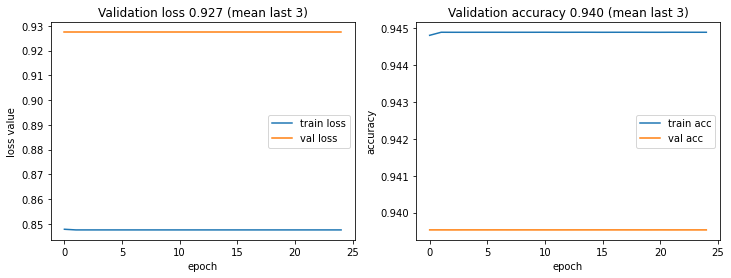

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.0994 - acc: 0.967

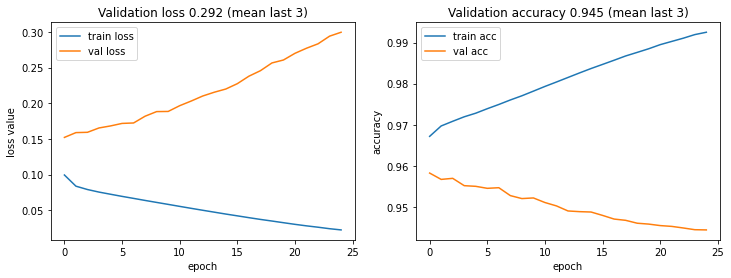

Test loss: 0.16
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.9976 - acc: 0.9351

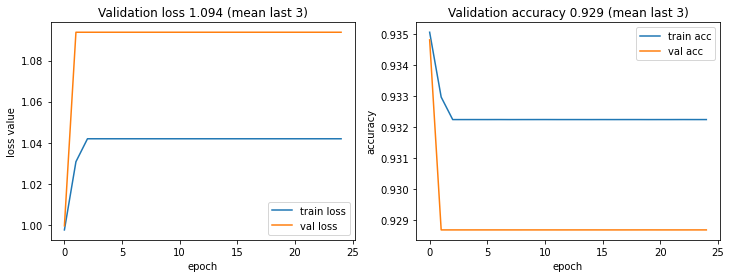

Test loss: 1.05
Test accuracy: 93.12%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 24us/sample - loss: 0.0978 - acc: 0.967

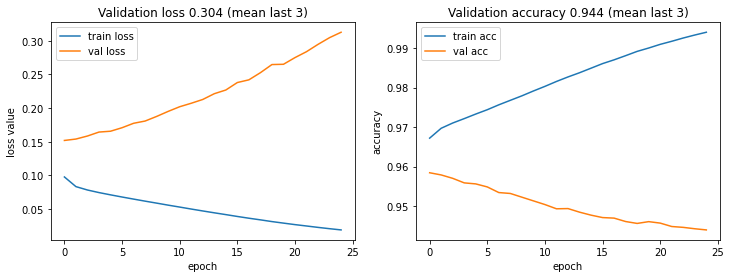

Test loss: 0.17
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.8917 - acc: 0.9420 

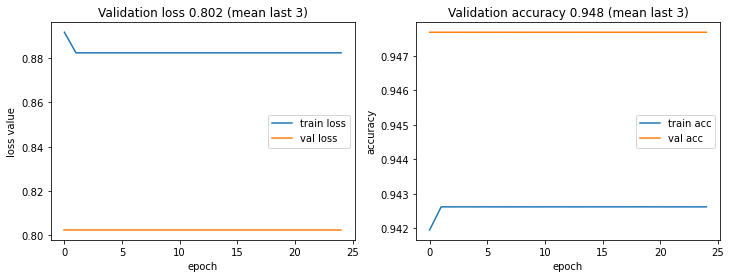

Test loss: 0.90
Test accuracy: 94.15%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8988      
Total params: 1,033,948
Trainable params: 1,033,948
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 samples, validate on 29620 samples
Epoch 1/25
118476/118476 [==============================] - 3s 25us/sample - loss: 0.1229 - acc: 0.9643

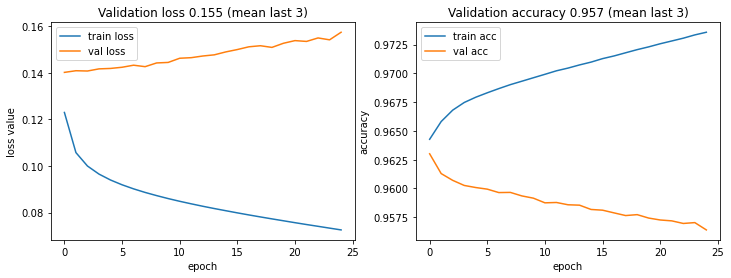

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

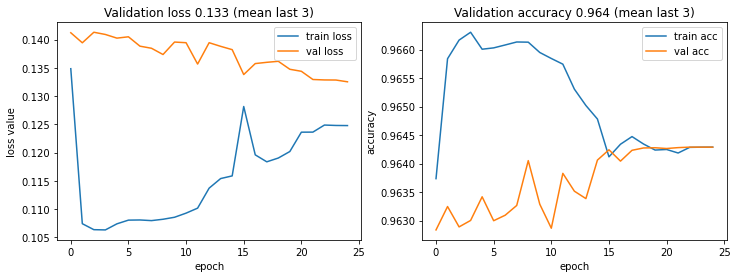

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 

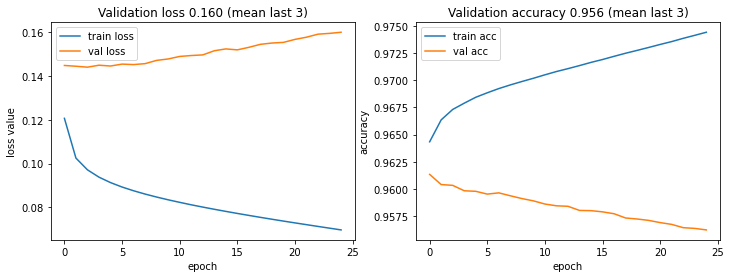

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

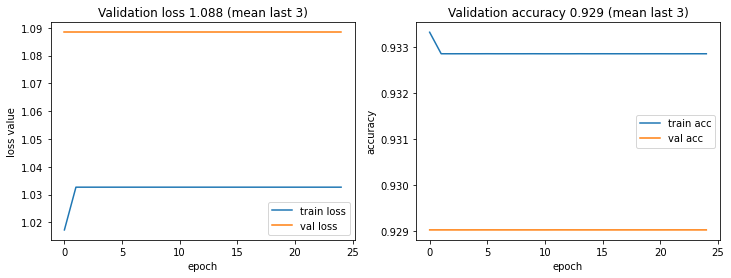

Test loss: 1.05
Test accuracy: 93.19%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 

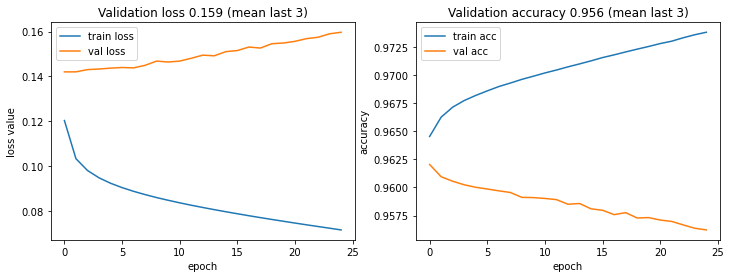

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 sa

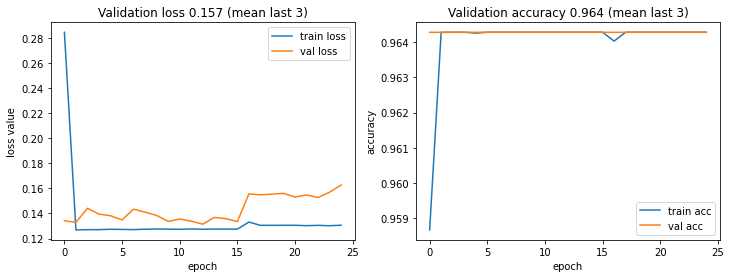

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

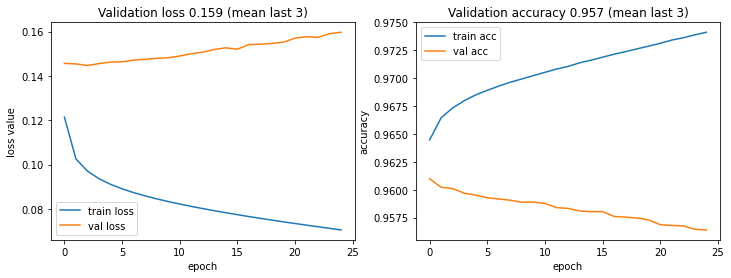

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

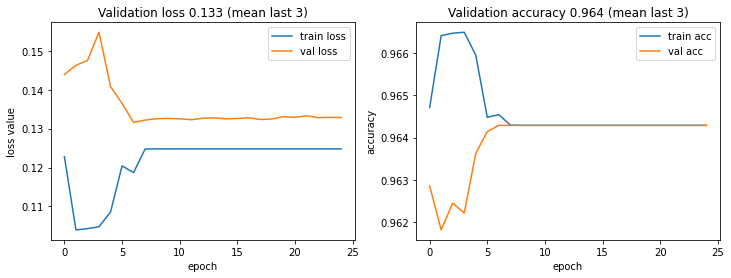

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 

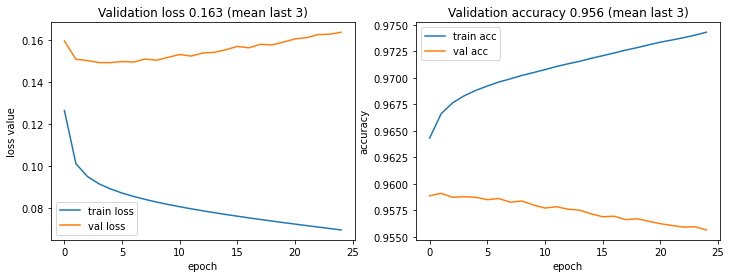

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

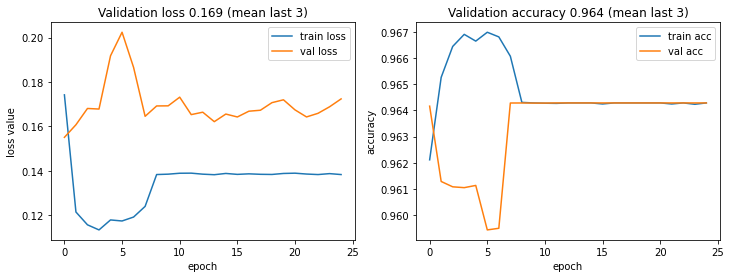

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 

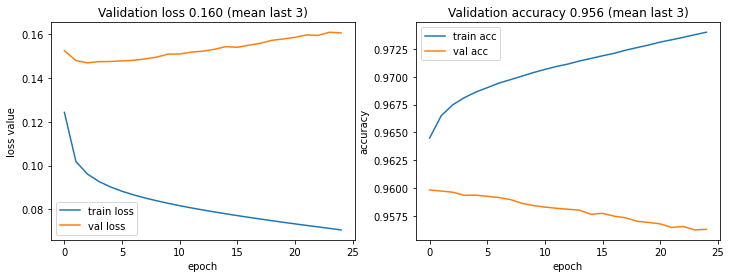

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 sa

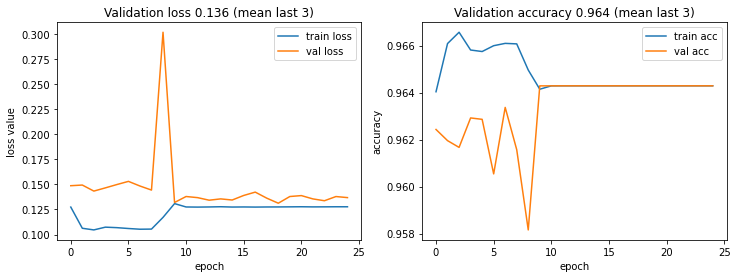

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

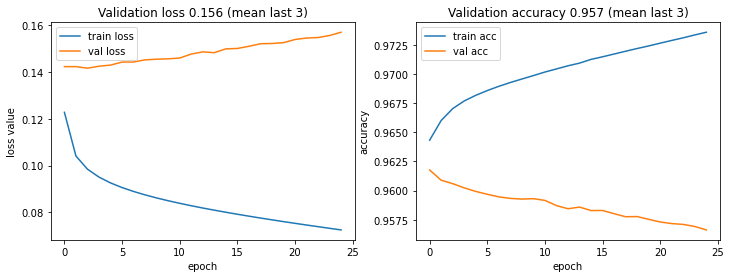

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 sa

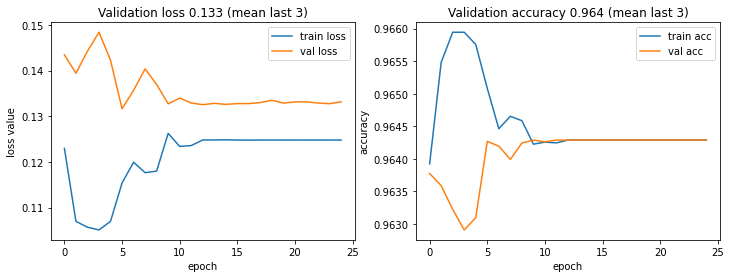

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

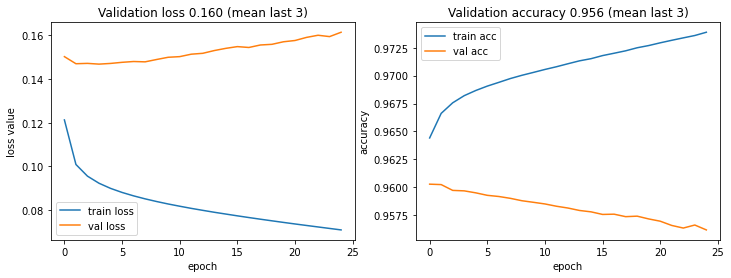

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 sa

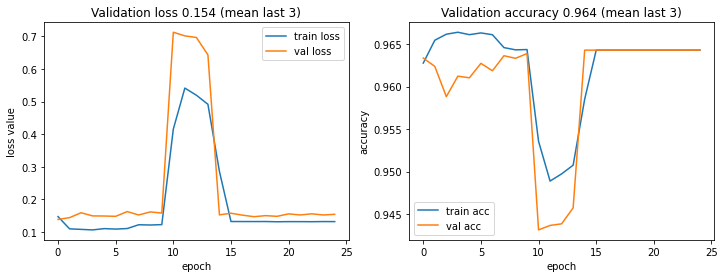

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 s

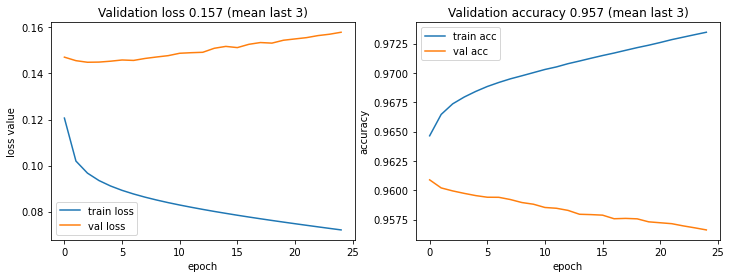

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 sam

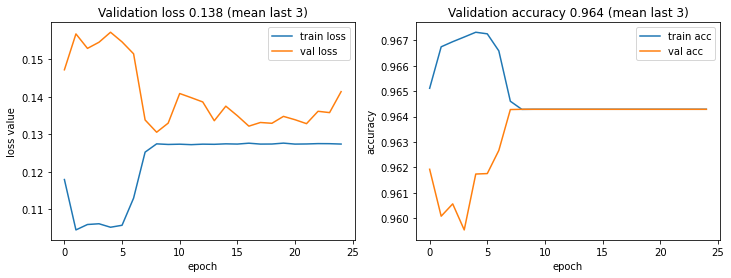

Test loss: 0.13
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 118476 sa

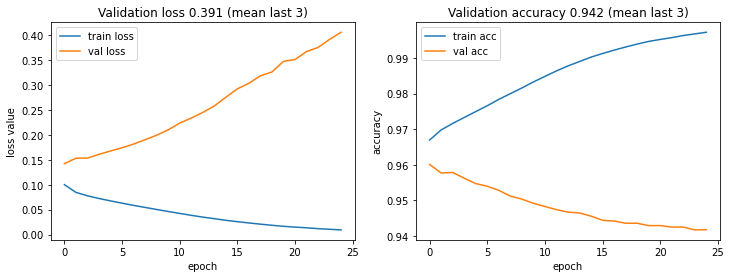

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

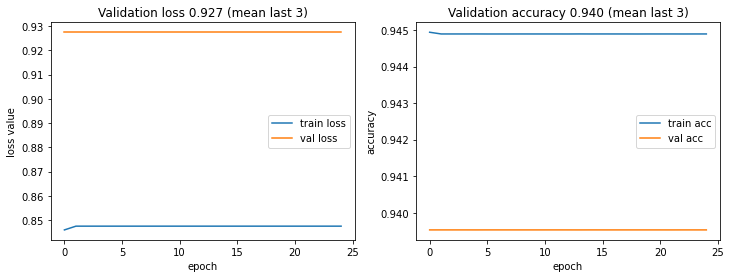

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 s

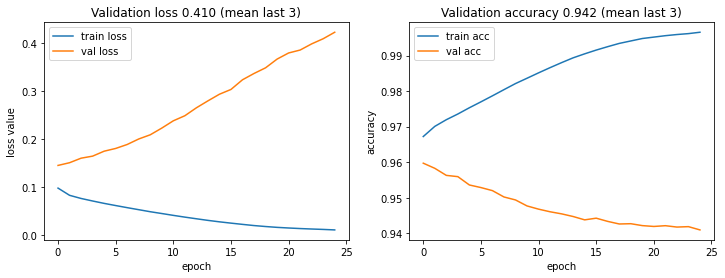

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

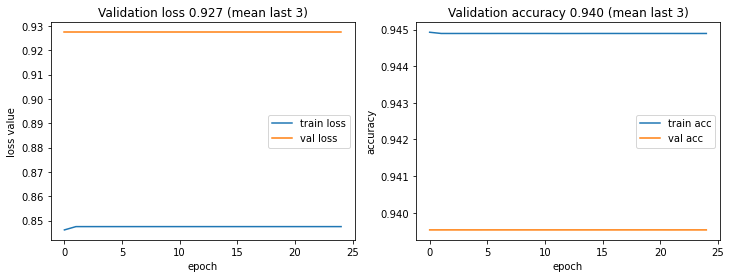

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 s

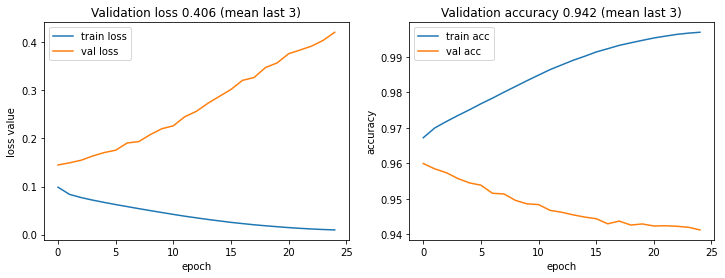

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sam

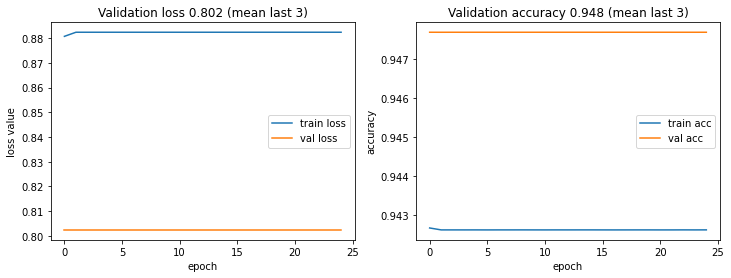

Test loss: 0.90
Test accuracy: 94.15%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

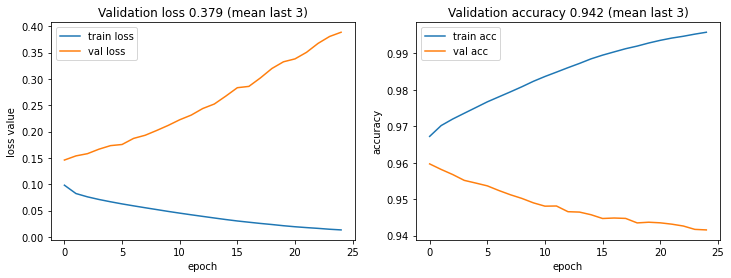

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

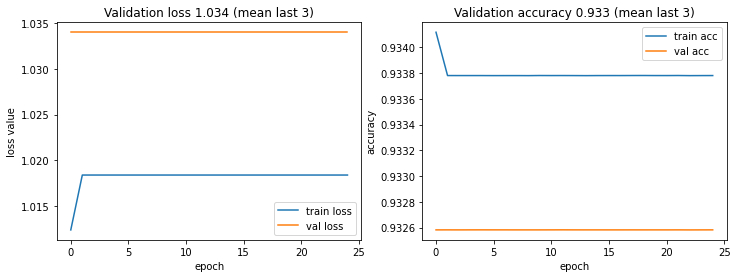

Test loss: 1.04
Test accuracy: 93.25%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 s

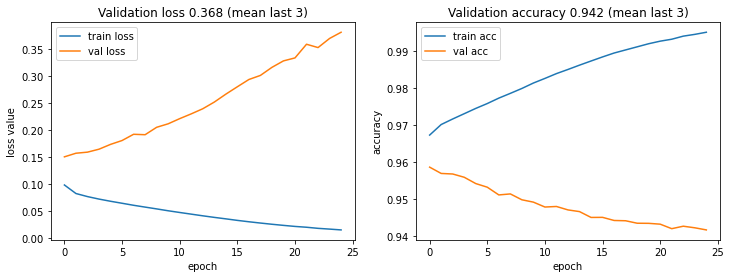

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

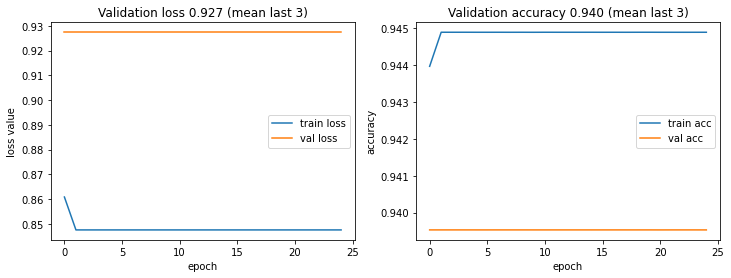

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 s

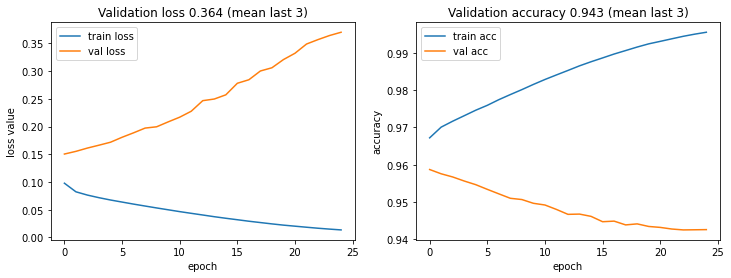

Test loss: 0.14
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sam

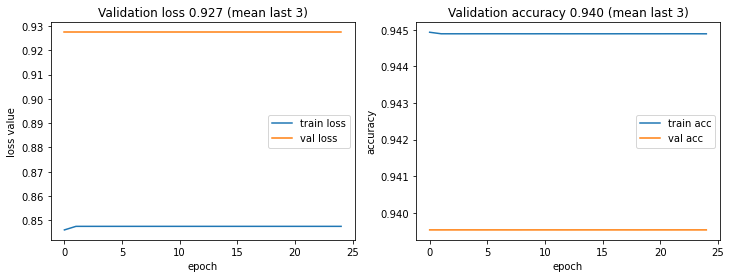

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

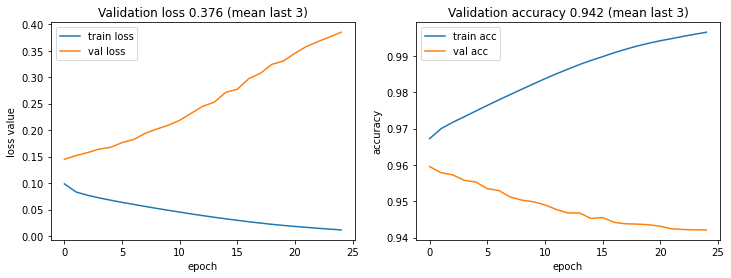

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sam

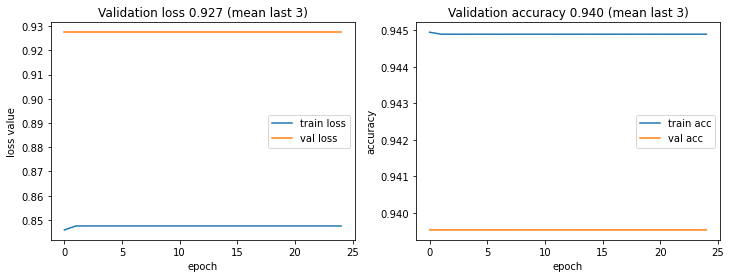

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

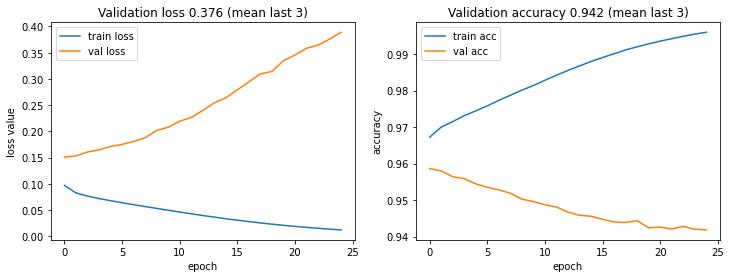

Test loss: 0.18
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sam

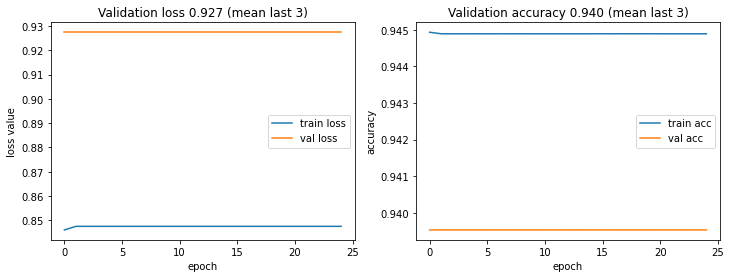

Test loss: 0.84
Test accuracy: 94.50%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 sa

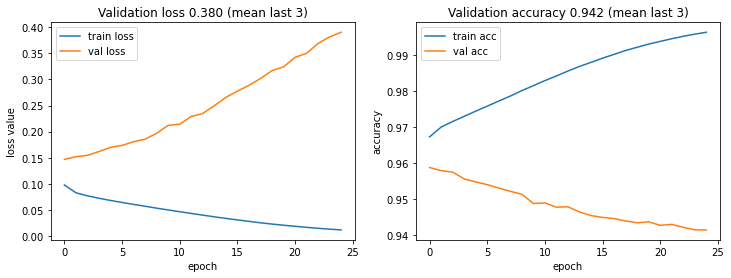

Test loss: 0.15
Test accuracy: 96.43%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 118476 samp

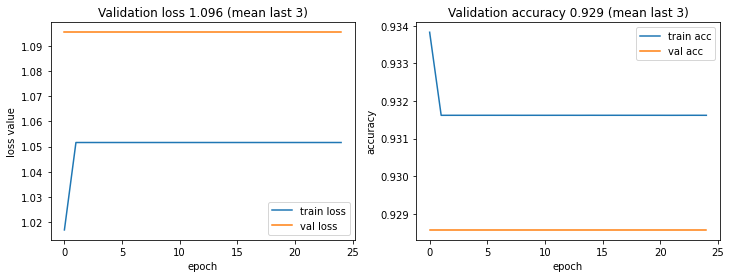

Test loss: 1.05
Test accuracy: 93.15%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 28)                4508      
Total params: 1,080,828
Trainable params: 1,080,828
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________







In [11]:
# set the catagory for the construction of the output target array of zeros
catagories = genres

# model 1
# loop through hyperparameters
for learning_rate in learning_rates: 
    for batch_size in batch_sizes:     
        for activation_1 in activation_values:
            for optimizer in optimizer_values:

                # an attempt to free gpu vram
                p = multiprocessing.Process(model_test(1, target = GENRE, activation_1 = activation_1, batch_size = batch_size, learning_rate = learning_rate, optimizer_name = optimizer))
                p.start()
                p.join()
                p.terminate()
                keras.backend.clear_session()
                # an attempt to free gpu vram
                
# model 2    
# loop through hyperparameters
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for activation_1 in activation_values:
            for activation_2 in activation_values:
                for optimizer in optimizer_values:

                    # an attempt to free gpu vram
                    p = multiprocessing.Process(model_test(2, target = GENRE, activation_1 = activation_1, activation_2 = activation_2, batch_size = batch_size, learning_rate = learning_rate, optimizer_name = optimizer))
                    p.start()
                    p.join()
                    p.terminate()
                    keras.backend.clear_session()
                    # an attempt to free gpu vram
                
#NOTE: some early executions of this Notebook failed with VRAM errors. It appeared that VRAM was not being freed. Some googling suggested using this multiprocessing solution. I do not know if this truely fixed the issue. But, since introducing it into the code here I have not seen the problem.

## Test the Models with the _STYLE_ Dataset.

Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 24us/sample - loss: 0.1170 - acc: 0.9664 - val_loss: 0.1694 - val_acc: 0.9623
Epoch 2/25
133376/133376 [==============================] - 3s 23us/sample - loss: 0.0981 - acc: 0.9682 - val_loss: 0.1778 - val_acc: 0.9618
Epoch 3/25
133376/133376 [==============================] - 3s 23us/sample - loss: 0.0927 - acc: 0.9691 - val_loss: 0.1838 - val_acc: 0.9614
Epoch 4/25
133376/133376 [==============================] - 3s 23us/sample - loss: 0.0894 - acc: 0.9697 - val_loss: 0.1879 - val_acc: 0.9612
Epoch 5/25
133376/133376 [==============================] - 3s 23us/sample - loss: 0.0870 - acc: 0.9702 - val_loss: 0.1911 - val_acc: 0.9608
Epoch 6/25
133376/133376 [==============================] - 3s 23us/sample - loss: 0.0852 - acc: 0.9706 - val_loss: 0.1939 - val_acc: 0.9608
Epoch 7/25
133376/133376 [==============================] - 3s 24us/sample - loss: 0.0836 - acc: 0.9709

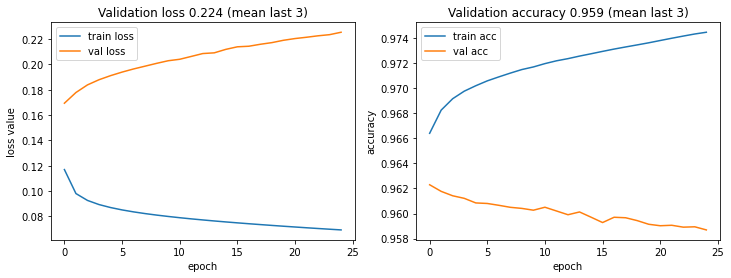

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 25us/sample - loss: 0.3107 - acc: 0.960

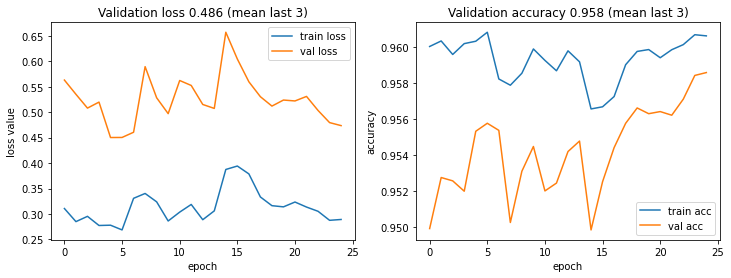

Test loss: 0.16
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 24us/sample - loss: 0.1250 - acc: 0.96

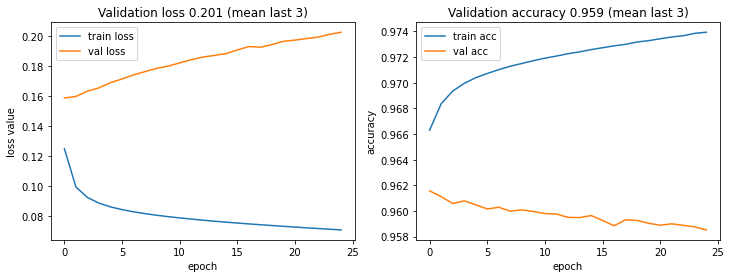

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 26us/sample - loss: 0.6402 - acc: 0.949

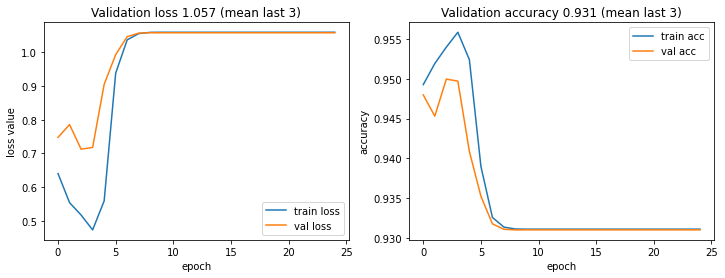

Test loss: 1.06
Test accuracy: 93.11%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 24us/sample - loss: 0.1182 - acc: 0.96

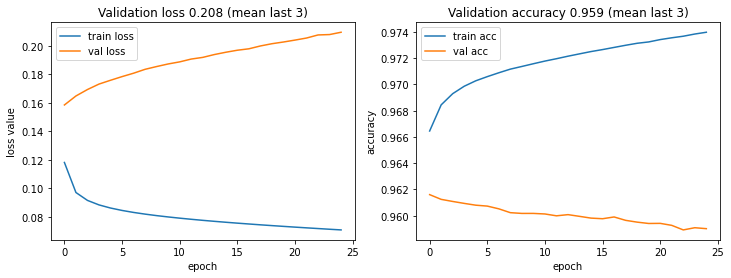

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 25us/sample - loss: 0.3936 - acc: 0.9554

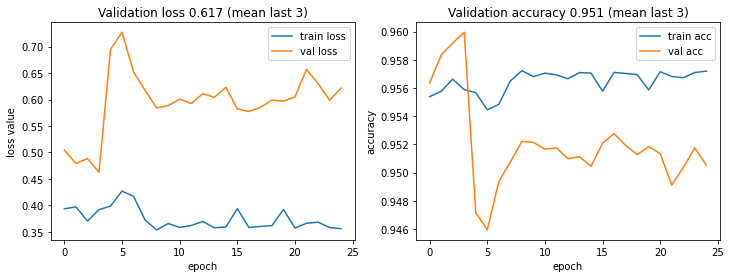

Test loss: 0.17
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 24us/sample - loss: 0.0933 - acc: 0.969

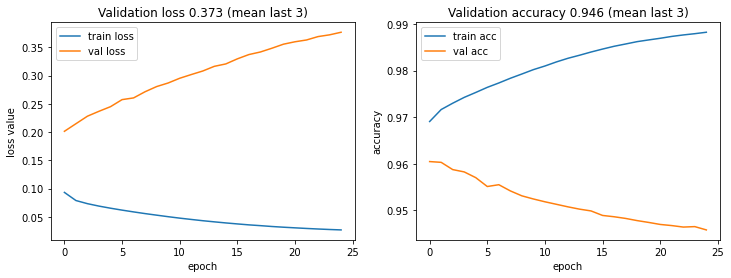

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 25us/sample - loss: 0.9553 - acc: 0.9378

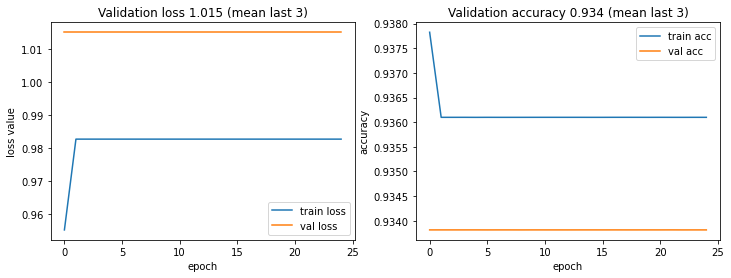

Test loss: 0.98
Test accuracy: 93.58%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: relu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 25us/sample - loss: 0.0951 - acc: 0.968

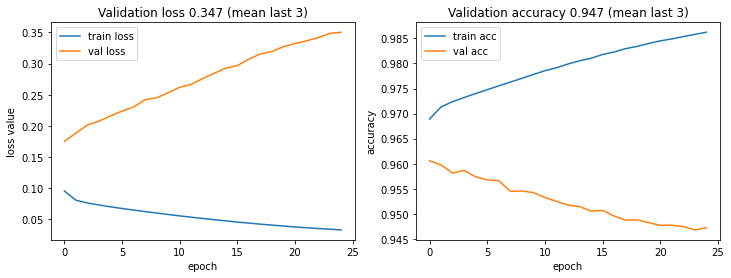

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 26us/sample - loss: 0.9430 - acc: 0.9386

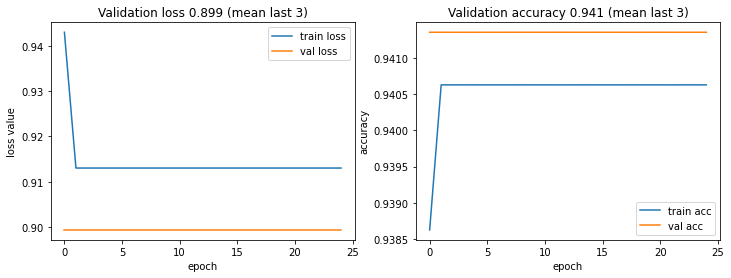

Test loss: 0.91
Test accuracy: 94.09%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: selu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 24us/sample - loss: 0.0933 - acc: 0.969

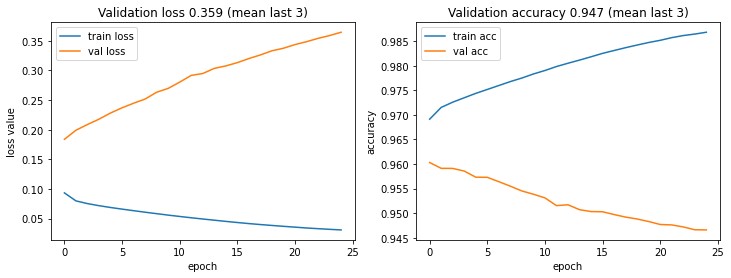

Test loss: 0.17
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 25us/sample - loss: 0.9469 - acc: 0.9384 

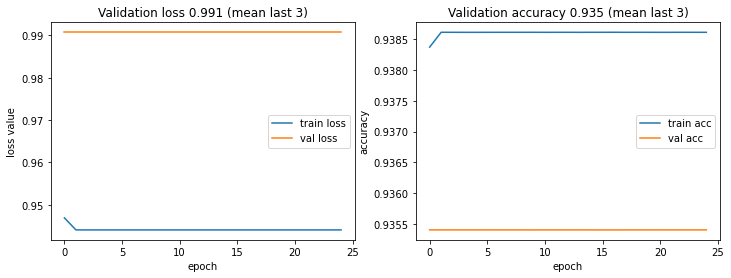

Test loss: 0.94
Test accuracy: 93.87%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 29)                9309      
Total params: 1,034,269
Trainable params: 1,034,269
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 1, activation_1: elu, activation_2: ,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 samples, validate on 33344 samples
Epoch 1/25
133376/133376 [==============================] - 3s 24us/sample - loss: 0.1192 - acc: 0.9661

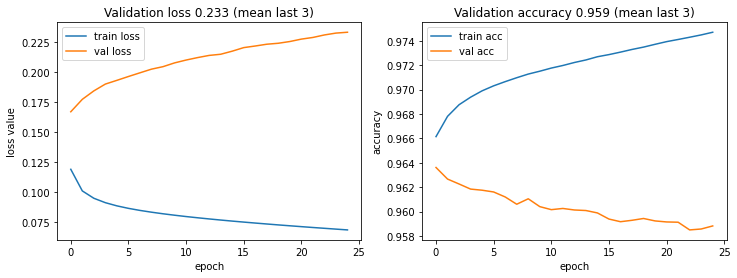

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

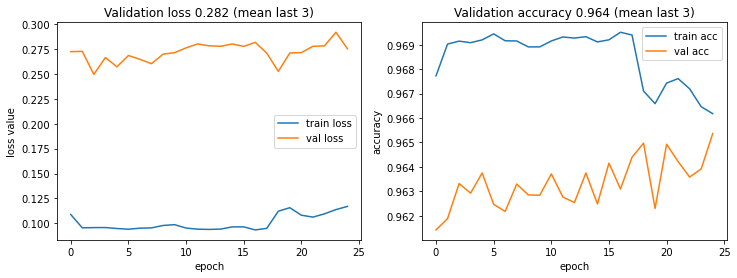

Test loss: 0.17
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 

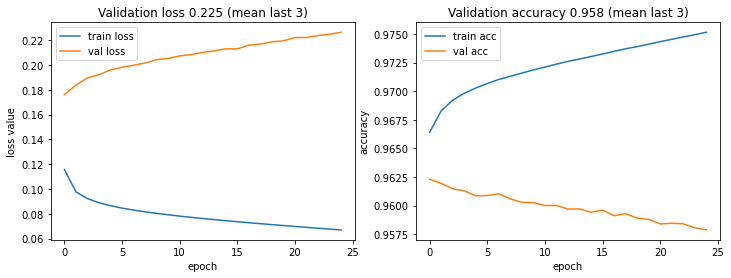

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

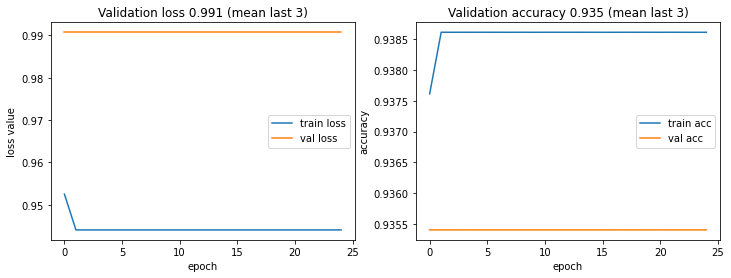

Test loss: 0.94
Test accuracy: 93.87%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 

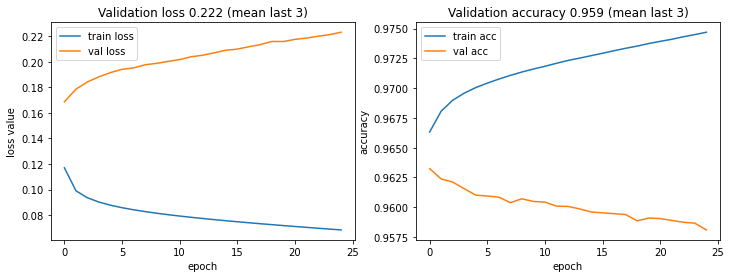

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 sa

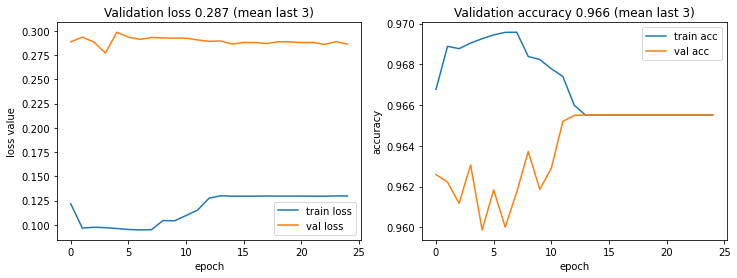

Test loss: 0.16
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

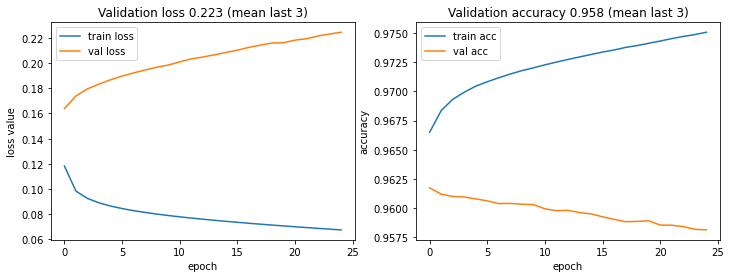

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

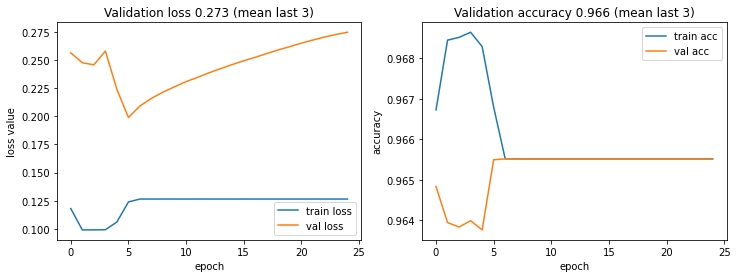

Test loss: 0.16
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 

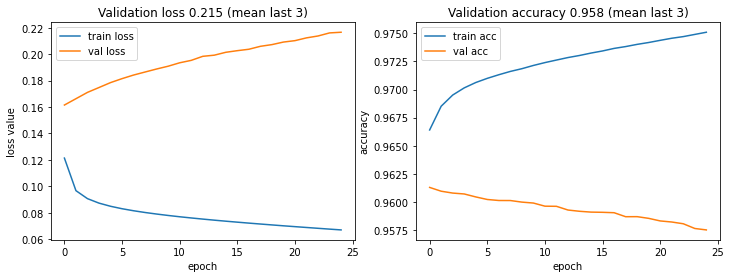

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

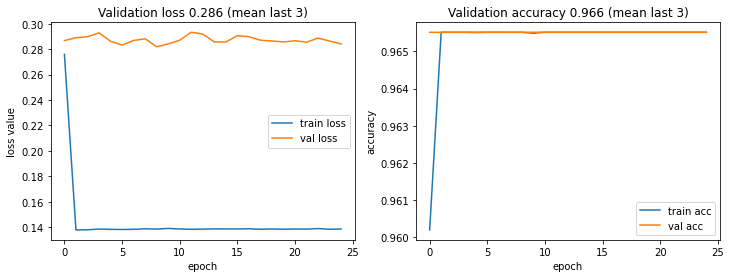

Test loss: 0.17
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 

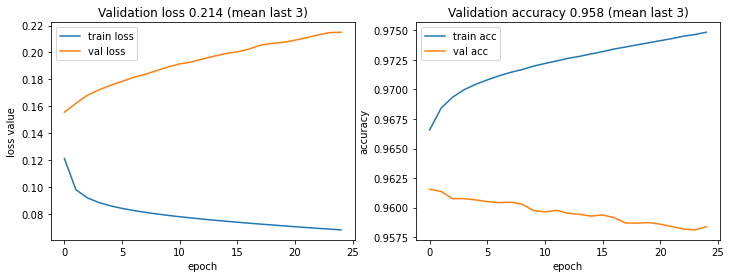

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 sa

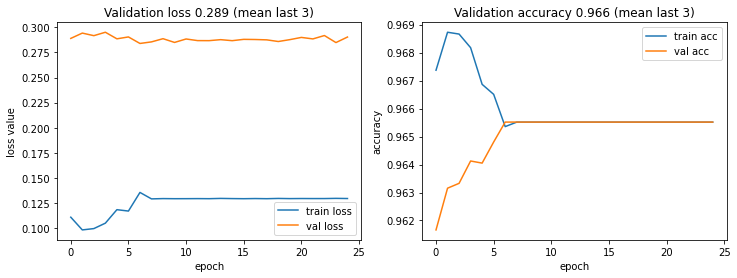

Test loss: 0.17
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

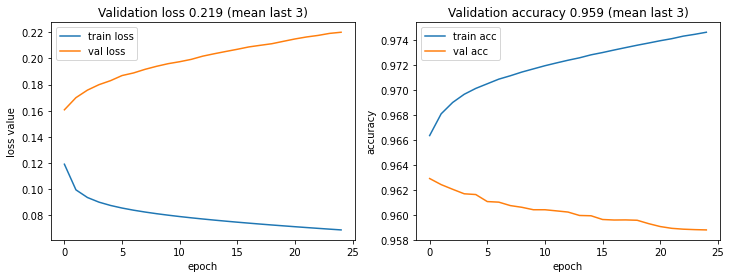

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 sa

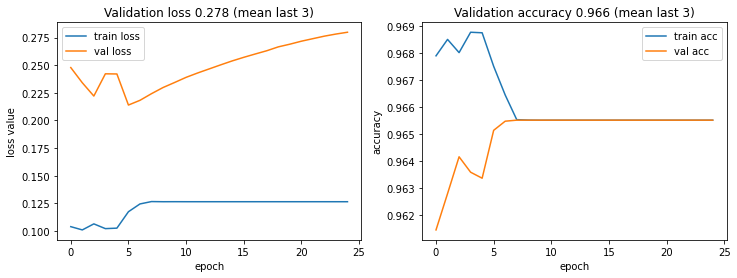

Test loss: 0.16
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

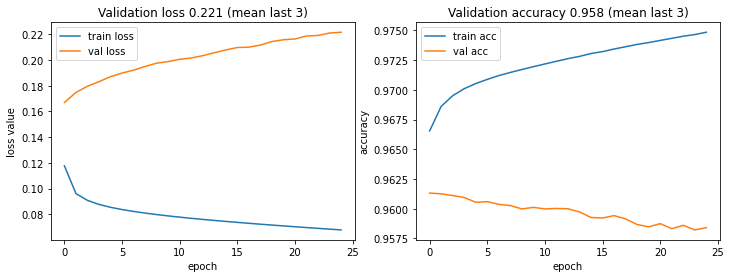

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 sa

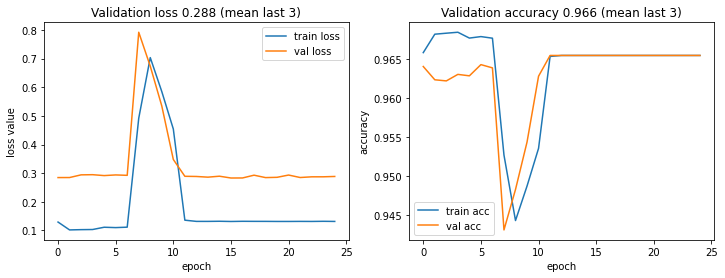

Test loss: 0.17
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 s

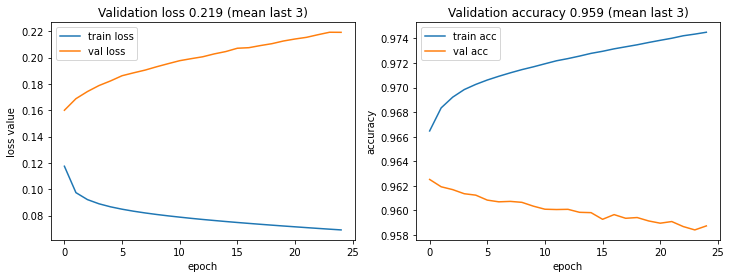

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 sam

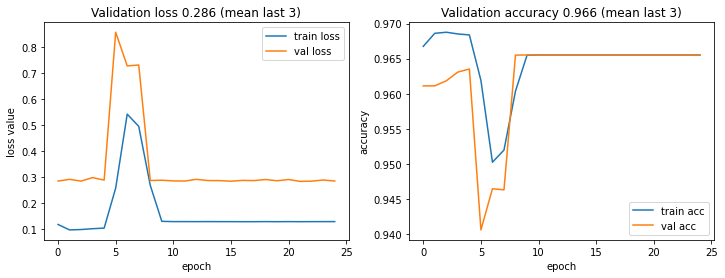

Test loss: 0.16
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.01
_________________________________________________________________





Train on 133376 sa

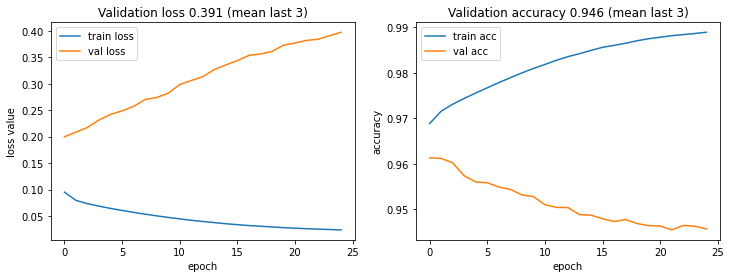

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

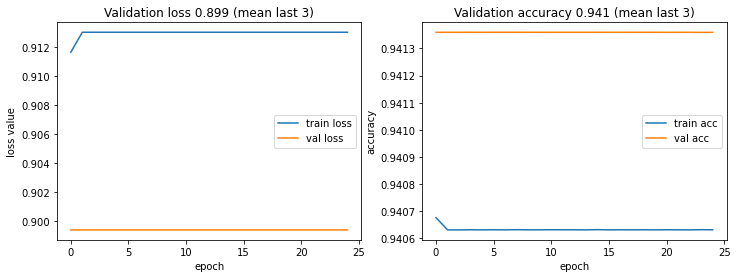

Test loss: 0.91
Test accuracy: 94.09%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 s

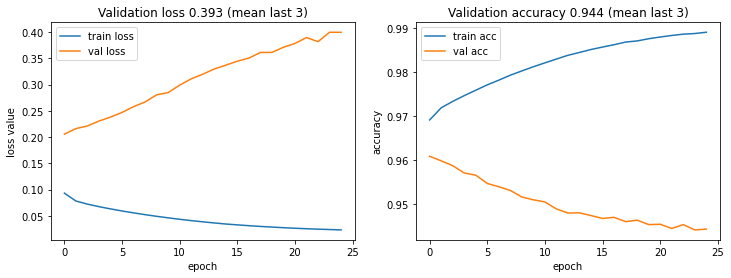

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

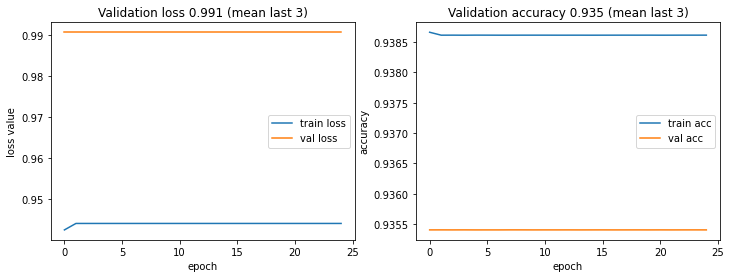

Test loss: 0.94
Test accuracy: 93.87%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 s

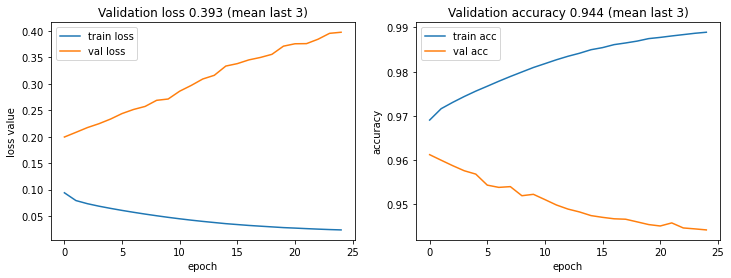

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sam

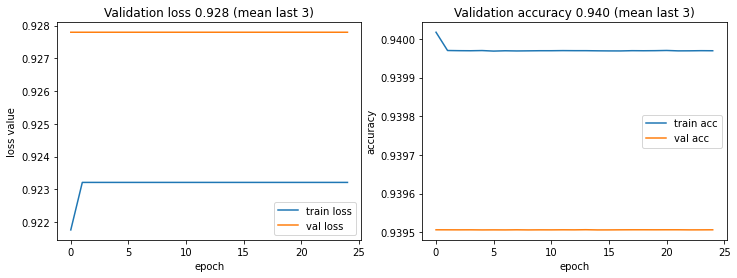

Test loss: 0.92
Test accuracy: 94.02%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: relu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

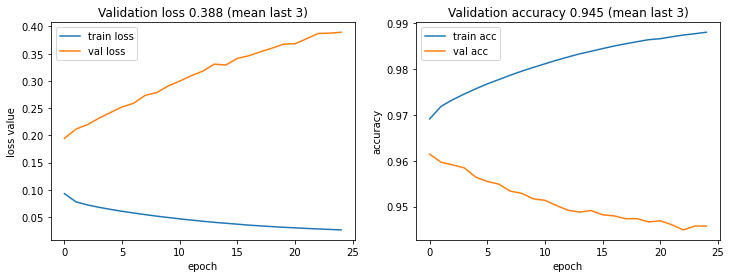

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

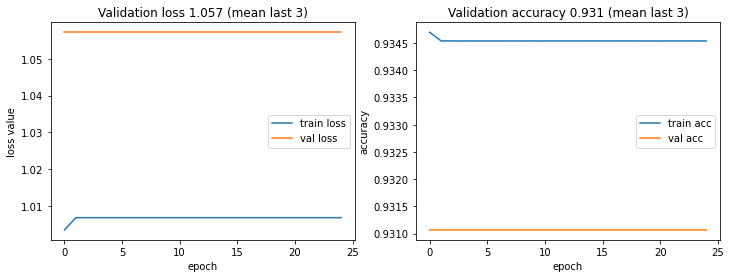

Test loss: 1.02
Test accuracy: 93.33%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 s

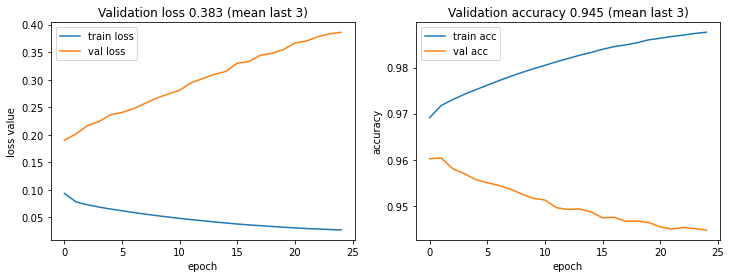

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

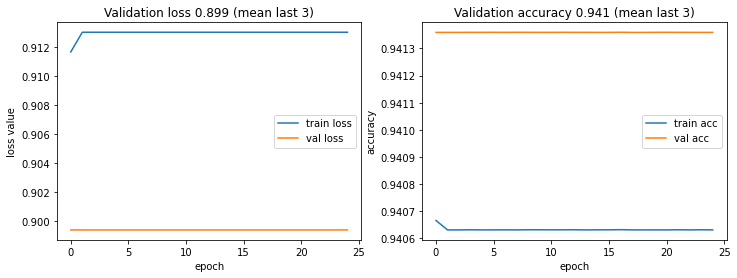

Test loss: 0.91
Test accuracy: 94.09%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 s

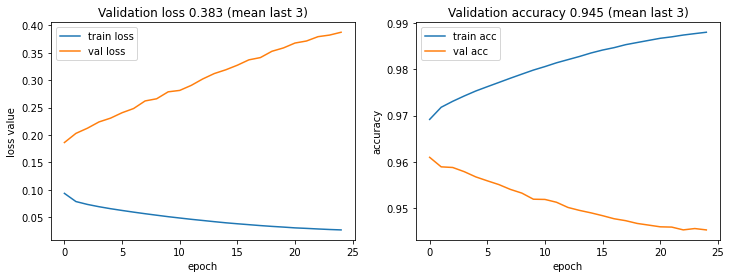

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sam

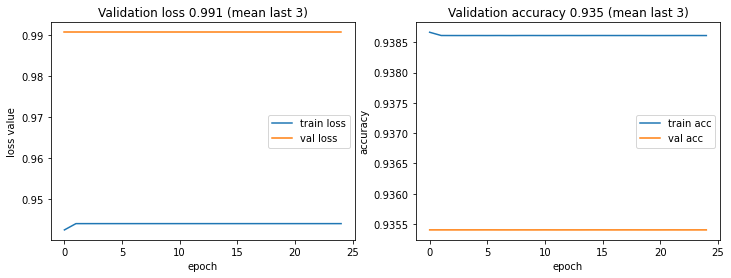

Test loss: 0.94
Test accuracy: 93.87%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: selu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

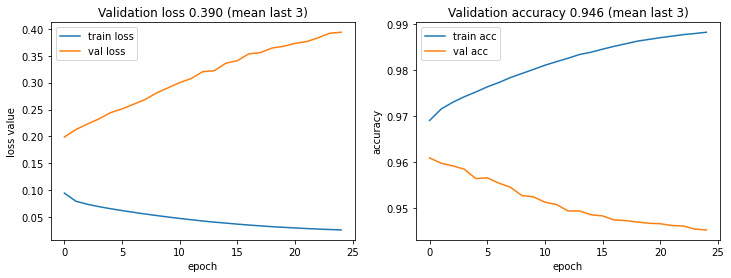

Test loss: 0.14
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sam

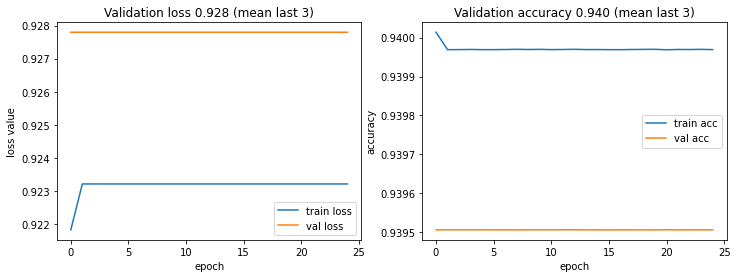

Test loss: 0.92
Test accuracy: 94.02%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: relu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

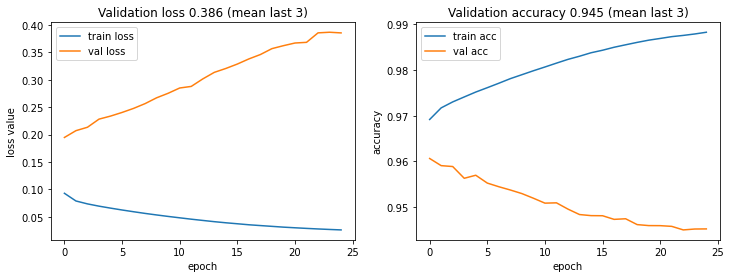

Test loss: 0.16
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sam

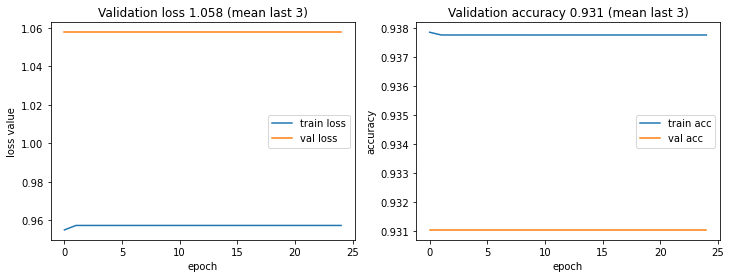

Test loss: 0.97
Test accuracy: 93.68%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: selu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 sa

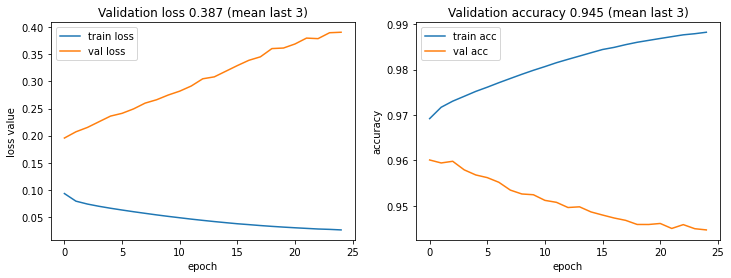

Test loss: 0.15
Test accuracy: 96.55%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: sgd, batch size: 256, learning rate: 0.1
_________________________________________________________________





Train on 133376 samp

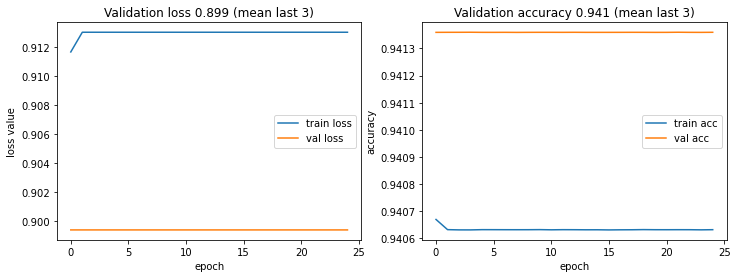

Test loss: 0.91
Test accuracy: 94.09%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4669      
Total params: 1,080,989
Trainable params: 1,080,989
Non-trainable params: 0
_________________________________________________________________
Parameters - model_id: 2, activation_1: elu, activation_2: elu,optimizer: adam, batch size: 256, learning rate: 0.1
_________________________________________________________________







In [12]:
# set the catagory for the construction of the output target array of zeros
catagories = styles

# model 1
# loop through hyperparameters
for learning_rate in learning_rates: 
    for batch_size in batch_sizes:     
        for activation_1 in activation_values:
            for optimizer in optimizer_values:

                # an attempt to free gpu vram
                p = multiprocessing.Process(model_test(1, target = STYLE, activation_1 = activation_1, batch_size = batch_size, learning_rate = learning_rate, optimizer_name = optimizer))
                p.start()
                p.join()
                p.terminate()
                keras.backend.clear_session()
                # an attempt to free gpu vram
                
# model 2    
# loop through hyperparameters
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for activation_1 in activation_values:
            for activation_2 in activation_values:
                for optimizer in optimizer_values:

                    # an attempt to free gpu vram
                    p = multiprocessing.Process(model_test(2, target = STYLE, activation_1 = activation_1, activation_2 = activation_2, batch_size = batch_size, learning_rate = learning_rate, optimizer_name = optimizer))
                    p.start()
                    p.join()
                    p.terminate()
                    keras.backend.clear_session()
                    # an attempt to free gpu vram
                
#NOTE: some early executions of this Notebook failed with VRAM errors. It appeared that VRAM was not being freed. Some googling suggested using this multiprocessing solution. I do not know if this truely fixed the issue. But, since introducing it into the code here I have not seen the problem.